<a href="https://colab.research.google.com/github/jgssung/IoT_Lab2/blob/main/IoT_Lab2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Device: cpu
>>> Fashion-MNIST 로드 및 Non-IID 분할 중...

[Simulation] FedProx vs FedAvg (With Drop & Loss Tracking)
Round|Prox Acc | Avg Acc |Prox Loss | Avg Loss | Drop 
  1  | 18.26  %| 18.47  %|  2.2115  |  2.2728  |  4   
  2  | 41.52  %| 24.25  %|  2.0040  |  2.2946  |  4   
  3  | 43.17  %| 32.37  %|  1.8860  |  1.8438  |  3   
  4  | 43.65  %| 43.01  %|  1.7195  |  1.3979  |  5   
  5  | 48.05  %| 39.22  %|  1.5991  |  1.8997  |  3   
  6  | 50.25  %| 35.87  %|  1.5362  |  2.3417  |  3   
  7  | 48.97  %| 41.86  %|  1.5038  |  2.7059  |  4   
  8  | 40.89  %| 33.65  %|  1.7007  |  2.4107  |  3   
  9  | 50.70  %| 44.99  %|  1.3512  |  1.9419  |  2   
 10  | 54.92  %| 52.27  %|  1.3262  |  1.8195  |  4   
 11  | 59.78  %| 43.16  %|  1.2008  |  1.9899  |  3   
 12  | 50.62  %| 44.28  %|  1.2416  |  1.5780  |  5   
 13  | 48.70  %| 43.99  %|  1.2712  |  1.6663  |  3   
 14  | 55.97  %| 49.63  %|  1.1857  |  1.4962  |  3   
 15  | 62.77  %| 51.44  %|  1.1494  |  1.6747  |  1   
 16

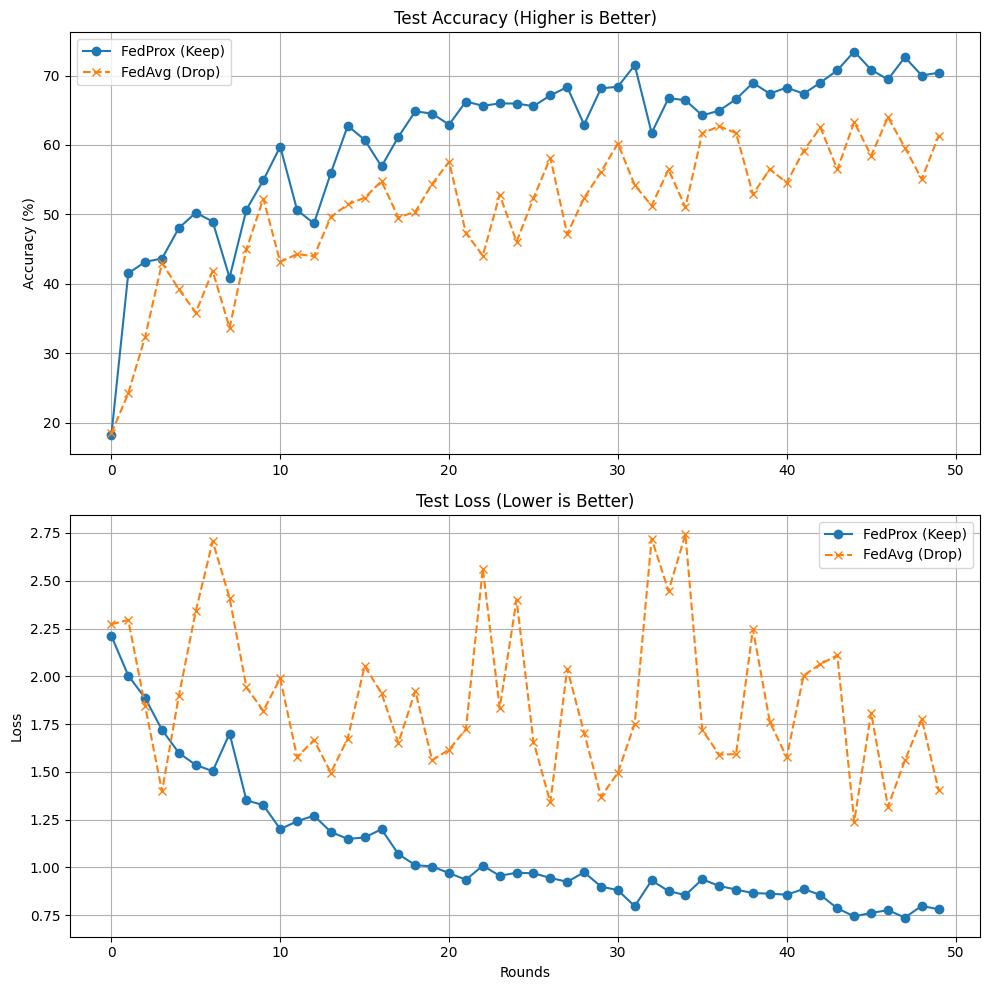

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

# ==============================================================================
# [설정] Code 3 기반 + FedAvg Drop + Loss 출력 추가
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# 1. 실험 환경 설정
NUM_CLIENTS = 20           # 전체 클라이언트
NUM_SELECTED = 10          # 라운드 당 참여 (50%)
NUM_ROUNDS = 50            # 총 라운드
BATCH_SIZE = 10            # 배치 사이즈

# 2. 하이퍼파라미터
LR = 0.1                   # 학습률
MU = 1.0                   # FedProx 규제 강도

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# ==============================================================================
# 1. Dataset: Fashion-MNIST (Non-IID Sharding)
# ==============================================================================
def get_fashion_mnist_noniid():
    print(">>> Fashion-MNIST 로드 및 Non-IID 분할 중...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random_state = np.random.RandomState(42)
    random_state.shuffle(shards)

    client_indices = []
    for i in range(NUM_CLIENTS):
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

# ==============================================================================
# 2. Model: SimpleNN
# ==============================================================================
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 3. Local Training
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device, client_id):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.client_id = client_id
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_model, mu, is_prox):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

        global_params = [p.clone().detach() for p in global_model.parameters()]

        # 낙오자 시뮬레이션 (3의 배수는 1 Epoch, 나머지는 5 Epoch)
        if self.client_id % 3 == 0:
            epochs = 1
        else:
            epochs = 5

        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        return model.state_dict(), len(self.loader.dataset)

# ==============================================================================
# 4. Server Logic (Evaluate 수정됨: Loss 반환)
# ==============================================================================
def average_weights(w_list, counts):
    if len(w_list) == 0:
        return None
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

def evaluate(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss() # Loss 계산기 추가
    correct = 0; total = 0
    test_loss = 0.0 # 누적 Loss

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            # Loss 계산
            loss = criterion(outputs, target)
            test_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader) # 평균 Loss

    return accuracy, avg_loss

# ==============================================================================
# 5. Main Experiment Loop
# ==============================================================================
def run_experiment():
    train_ds, test_ds, user_groups = get_fashion_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model_prox = SimpleNN().to(DEVICE)
    model_avg = SimpleNN().to(DEVICE)
    model_avg.load_state_dict(model_prox.state_dict())

    # 기록용 리스트 (정확도, 손실)
    hist_acc_prox, hist_loss_prox = [], []
    hist_acc_avg, hist_loss_avg = [], []

    print(f"\n[Simulation] FedProx vs FedAvg (With Drop & Loss Tracking)")
    print(f"{'Round':^5}|{'Prox Acc':^9}|{'Avg Acc':^9}|{'Prox Loss':^10}|{'Avg Loss':^10}|{'Drop':^6}")
    print("="*65)

    for round_idx in range(NUM_ROUNDS):
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # --- FedProx (Keep Stragglers) ---
        w_prox, s_prox = [], []
        for idx in idxs_users:
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE, client_id=idx)
            w, s = local.train(model_prox, MU, True)
            w_prox.append(w); s_prox.append(s)
        model_prox.load_state_dict(average_weights(w_prox, s_prox))

        # --- FedAvg (Drop Stragglers) ---
        w_avg, s_avg = [], []
        dropped_count = 0
        for idx in idxs_users:
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE, client_id=idx)
            w, s = local.train(model_avg, 0.0, False)
            if idx % 3 == 0:
                dropped_count += 1 # 1 Epoch만 한 애들은 버림
                continue
            w_avg.append(w); s_avg.append(s)

        if len(w_avg) > 0:
            model_avg.load_state_dict(average_weights(w_avg, s_avg))

        # --- 평가 (정확도 & Loss) ---
        acc_prox, loss_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_avg, loss_avg = evaluate(model_avg, test_loader, DEVICE)

        hist_acc_prox.append(acc_prox); hist_loss_prox.append(loss_prox)
        hist_acc_avg.append(acc_avg); hist_loss_avg.append(loss_avg)

        print(f"{round_idx+1:^5}|{acc_prox:^8.2f}%|{acc_avg:^8.2f}%|{loss_prox:^10.4f}|{loss_avg:^10.4f}|{dropped_count:^6}")

    # --- 그래프 그리기 (위: 정확도, 아래: Loss) ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # 1. 정확도 그래프
    ax1.plot(hist_acc_prox, 'o-', label='FedProx (Keep)')
    ax1.plot(hist_acc_avg, 'x--', label='FedAvg (Drop)')
    ax1.set_title("Test Accuracy (Higher is Better)")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend()
    ax1.grid()

    # 2. Loss 그래프
    ax2.plot(hist_loss_prox, 'o-', label='FedProx (Keep)')
    ax2.plot(hist_loss_avg, 'x--', label='FedAvg (Drop)')
    ax2.set_title("Test Loss (Lower is Better)")
    ax2.set_xlabel("Rounds")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment()

데이터를 다운로드 중입니다...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


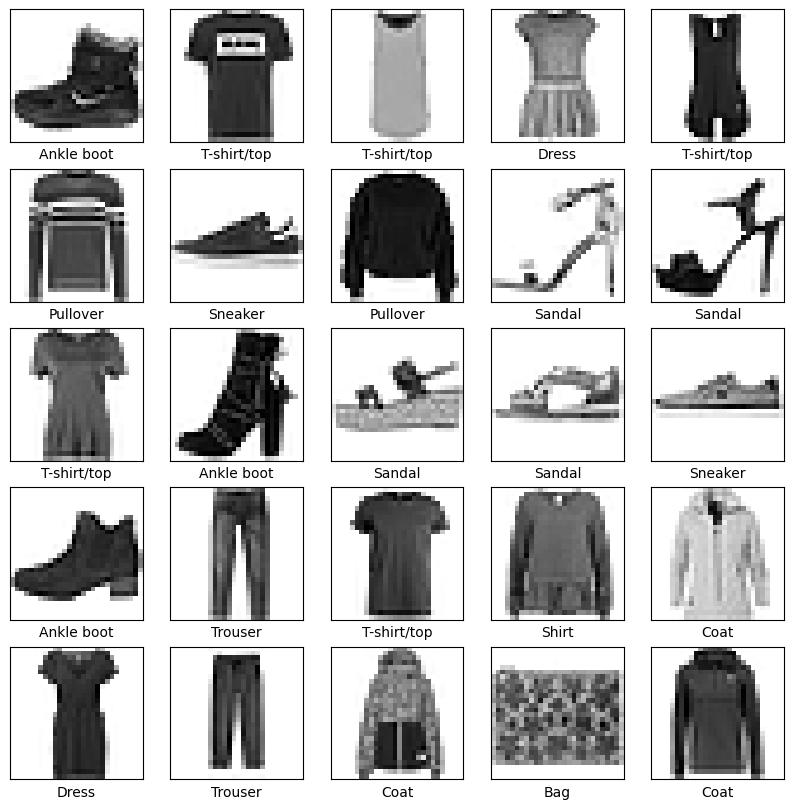

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (인터넷에서 자동 다운로드)
print("데이터를 다운로드 중입니다...")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# 2. 옷 이름 리스트 (숫자 라벨을 사람이 읽을 수 있게 변환용)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 3. 이미지 출력하기 (처음 25개만 그리드로 보여줌)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # 이미지 데이터 보여주기 (흑백)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # 아래에 옷 이름 라벨 달기
    plt.xlabel(class_names[train_labels[i]])
plt.show()